<a href="https://colab.research.google.com/github/dineshdevkota001/dogGenerator/blob/master/flowerGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DCGAN Testing sandbox

---



---



import libraries

In [1]:
import os,time
from google.colab import drive
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import glob
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np,pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



TensorFlow 2.x selected.


mount the storage

In [2]:
drive.mount('/content/drive')
if not os.path.exists('/content/flowers'):
  !unzip -qq '/content/drive/My Drive/Data/flowers'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


define constants

In [0]:
# constants
ROOT = '/content/flowers'
BREEDS = os.listdir(ROOT)
BATCH_SIZE = 64
BUFFER_SIZE = 3553
IMAGE_DIM = 64
IMAGE_CHANNEL = 3
NOISE = 500

TAKE dATA

In [0]:
images = np.zeros((3550,64,64,3))
labels = np.zeros((3550))
count = 0

for l,breed in enumerate(BREEDS,start=1):
  source = ROOT+'/'+breed
  for flower in os.listdir(source):
    image = Image.open(source+'/'+flower)
    image = image.resize((IMAGE_DIM,IMAGE_DIM))
    images[count] = np.asarray(image).astype('float32')
    labels[count] = l
    count += 1

idx = np.arange(count)
idx = np.random.shuffle(idx)

images = images[idx,:,:,:]
labels = labels[idx,:]


Preprocess and shuffle data

(1, 3550, 64, 64, 3)


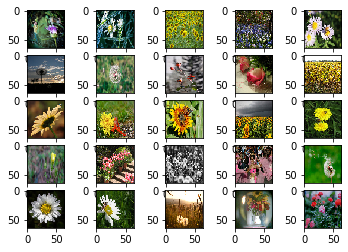

In [22]:
print(images.shape)
print(labels.shape)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(images[0,np.random.randint(3500),:,:,:].astype('uint8'))
images = images/255.

Define Generator

In [0]:
def createGenerator():
  generator = tf.keras.Sequential()

  # first densely connected network to upscale the image to required dimension
  generator.add(layers.Dense(16*16*128,use_bias=False,input_shape = (NOISE,)))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())
# 1 is the standard deviation of the normal distribution
# 100 is the number of elements you get in array noise
  generator.add(layers.Reshape((16,16,128)))
  assert generator.output_shape == (None,16,16,128)

  generator.add(layers.Conv2DTranspose(64,(5,5),strides=(1,1),use_bias=False,padding='same'))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())
  assert generator.output_shape == (None,16,16,64)

  generator.add(layers.Conv2DTranspose(32,(5,5),strides=(2,2),use_bias=False,padding='same'))
  generator.add(layers.LeakyReLU())

  generator.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding='same',activation = 'tanh'))
  assert generator.output_shape == (None, 64, 64, 3)
  return generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


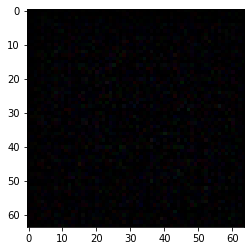

In [0]:
generator = createGenerator()
#generate noise to feed the generator
generated_noise = tf.random.normal([1,NOISE])
generated_image = generator(generated_noise, training=False)
#convert it to array for storing
arr = np.asarray(generated_image).astype('uint8')
# check the images
plt.imshow(arr[0,:,:,:])

Define Discriminator

In [0]:
def createDiscriminator():
  model = tf.keras.Sequential()   
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[64, 64, 3]))
  print(model.output_shape)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  print(model.output_shape)
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

Make Generator and Discriminator

In [0]:
discriminator= createDiscriminator()
prediction = discriminator(generated_image)
print(prediction)

(None, 32, 32, 64)
(None, 16, 16, 128)
tf.Tensor([[-0.0006148]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Losses and optimizers

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


seed = tf.random.normal([16, NOISE])

make GAN and compile it

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Train Gan Function

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [0]:
train(images, 20 00)

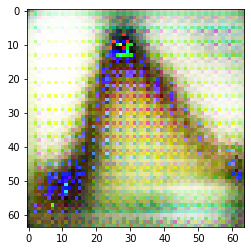

In [0]:
#generate noise to feed the generator
generated_noise = tf.random.normal([1,NOISE])
generated_image = generator(generated_noise, training=False)
#convert it to array for storing
arr = np.asarray(generated_image)*255
# check the images
plt.imshow(arr[0,:,:,:].astype('uint8'))

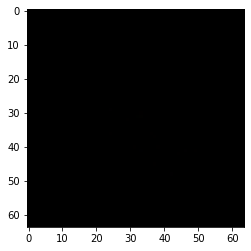

In [0]:
x = np.random.randint(3550)
plt.imshow(images[0,x,:,:,:].astype('uint8'))